In [6]:
from google.colab import auth
auth.authenticate_user()
print('Authenticated')

Authenticated


In [7]:
!sudo pip install google-cloud-bigquery google-cloud-storage pandas pandas-gbq gcsfs oauth2client
import datetime
import pandas as pd
import gcsfs
from google.cloud import bigquery
from google.cloud import storage

In [0]:
client_bq = bigquery.Client(location='US', project="cryptic-honor-259622")

In [9]:
%%bigquery --project cryptic-honor-259622
CREATE OR REPLACE MODEL
  house_price.hpcluster OPTIONS(model_type='kmeans',
  num_clusters=4) AS
WITH
  stationstats AS (
    SELECT
      *
    FROM
      `cryptic-honor-259622.house_price.test` AS test
    UNION ALL
    SELECT
      *
    FROM
      `cryptic-honor-259622.house_price.train_f` AS train_f
)
SELECT
  * EXCEPT(trans_date, house_age, distance_mrt, stores)
FROM
  stationstats;



""


In [0]:
query = """
WITH
  stationstats AS (
    SELECT
      *, 1 AS type
    FROM
      `cryptic-honor-259622.house_price.train_f` AS train_f
    UNION ALL
    SELECT
      *, 0 AS type
    FROM
      `cryptic-honor-259622.house_price.test` AS test
)
SELECT
  * EXCEPT(nearest_centroids_distance)
FROM
  ML.PREDICT( MODEL house_price.hpcluster,
    (
    SELECT
      *
    FROM
      stationstats  
)) AS MLP
WHERE
MLP.type = 1
"""

train_f = client_bq.query(query).to_dataframe()


In [11]:
train_f.head()

,CENTROID_ID,trans_date,house_age,distance_mrt,stores,latitude,longitude,type
0,4,2013.000000,17.6,837.7233,0,24.96334,121.54767,1
1,4,2013.000000,8.9,3078.1760,0,24.95464,121.56627,1
2,1,2013.583333,4.0,2147.3760,3,24.96299,121.51284,1
3,1,2013.500000,13.5,2147.3760,3,24.96299,121.51284,1
4,1,2013.500000,4.0,2147.3760,3,24.96299,121.51284,1


In [0]:
query = """
SELECT *
FROM `cryptic-honor-259622.house_price.train_l`;
"""
train_l = client_bq.query(query).to_dataframe()

In [13]:
train_l.head()

,house_price
0,13.0
1,15.5
2,19.0
3,20.0
4,22.0


In [14]:
import pandas as pd
train = pd.concat([train_f, train_l], axis=1 )
train.head()


,CENTROID_ID,trans_date,house_age,distance_mrt,stores,latitude,longitude,type,house_price
0,4,2013.000000,17.6,837.7233,0,24.96334,121.54767,1,13.0
1,4,2013.000000,8.9,3078.1760,0,24.95464,121.56627,1,15.5
2,1,2013.583333,4.0,2147.3760,3,24.96299,121.51284,1,19.0
3,1,2013.500000,13.5,2147.3760,3,24.96299,121.51284,1,20.0
4,1,2013.500000,4.0,2147.3760,3,24.96299,121.51284,1,22.0


In [15]:
query = """
WITH
  stationstats AS (
    SELECT
      *, 1 AS type
    FROM
      `cryptic-honor-259622.house_price.train_f` AS train_f
    UNION ALL
    SELECT
      *, 0 AS type
    FROM
      `cryptic-honor-259622.house_price.test` AS test
)
SELECT
  * EXCEPT(nearest_centroids_distance)
FROM
  ML.PREDICT( MODEL house_price.hpcluster,
    (
    SELECT
      *
    FROM
      stationstats  
)) AS MLP
WHERE
MLP.type = 0
"""
test = client_bq.query(query).to_dataframe()
test.head()

,CENTROID_ID,trans_date,house_age,distance_mrt,stores,latitude,longitude,type
0,4,2012.916667,18.9,1009.2350,0,24.96357,121.54951,0
1,4,2013.250000,35.8,170.7311,7,24.96719,121.54269,0
2,2,2012.666667,34.5,623.4731,7,24.97933,121.53642,0
3,2,2013.166667,39.2,424.7132,7,24.97429,121.53917,0
4,2,2012.916667,34.8,190.0392,8,24.97707,121.54312,0


## EDA


In [0]:
import seaborn as sns #visualisation
import matplotlib.pyplot as plt #visualisation
%matplotlib inline 
sns.set(color_codes=True)

In [17]:
# check missing data
print(train.isnull().sum())

CENTROID_ID     0
trans_date      0
house_age       0
distance_mrt    0
stores          0
latitude        0
longitude       0
type            0
house_price     0
dtype: int64


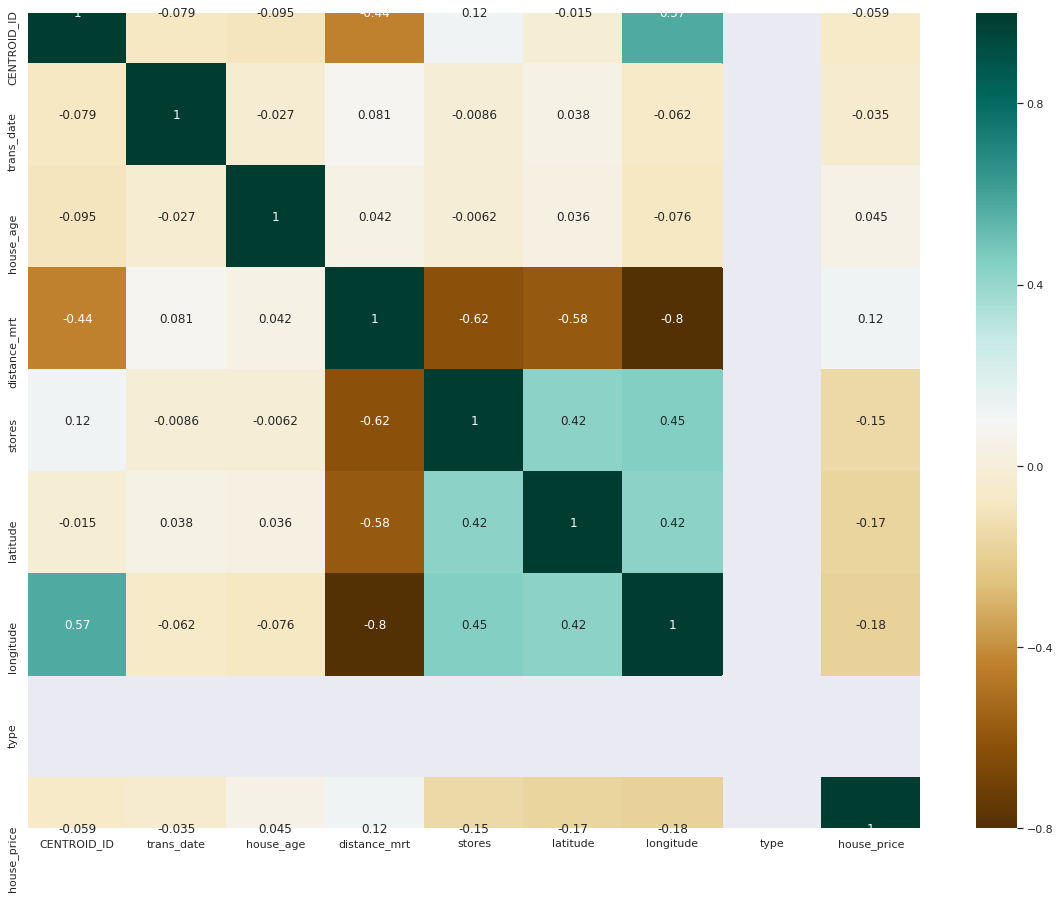

In [18]:
# check correlation between features
plt.figure(figsize = (20, 15))
c = train.corr()
sns.heatmap(c, cmap="BrBG", annot = True)

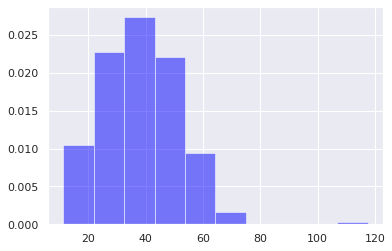

In [19]:
# distribution of house price
num_bins = 10
plt.hist(train['house_price'], num_bins, density = True, facecolor='blue', alpha=0.5)
plt.show()

In [21]:
import plotly.express as px
train_plt = train.copy()
train_plt["CENTROID_ID"] = train_plt["CENTROID_ID"].astype(str)
fig = px.scatter_mapbox(train_plt, lat="latitude", lon="longitude", hover_name="house_price",
             zoom = 12, color = "CENTROID_ID",
)
fig.update_layout(mapbox_style = "open-street-map",
         title = 'The Scatterplot of House Location',
         geo_scope = 'asia',
        )

fig.show()

In [22]:
!pip install datalab

In [23]:
from IPython.core.display import HTML
HTML("<script>Jupyter.notebook.kernel.restart()</script>")

In [0]:
# export train test data to gsc
import datalab.storage as gcs
gcs.Bucket('final_5671').item('train.csv').write_to(train.to_csv(), 'text/csv')
gcs.Bucket('final_5671').item('test.csv').write_to(test.to_csv(), 'text/csv')

## Model


In [26]:
%%bigquery --project cryptic-honor-259622
#create linear regression model
CREATE MODEL `data.lr_model`
OPTIONS
  (model_type='linear_reg',
    input_label_cols=['house_price']) AS
SELECT
  house_price,
  CAST(CENTROID_ID AS STRING) AS CENTROID_ID,
  house_age,
  distance_mrt,
  stores
FROM
  `cryptic-honor-259622.data.train`

""


In [27]:
%%bigquery --project cryptic-honor-259622
#evalue model
SELECT
  *
FROM
  ML.EVALUATE(MODEL `data.lr_model`,
    (
    SELECT
      house_price,
      CAST(CENTROID_ID AS STRING) AS CENTROID_ID,
      house_age,
      distance_mrt,
      stores
    FROM
`cryptic-honor-259622.data.train`))

,mean_absolute_error,mean_squared_error,mean_squared_log_error,median_absolute_error,r2_score,explained_variance
0,10.512136,180.274361,0.138993,8.713106,0.053412,0.053412


In [29]:
%%bigquery --project cryptic-honor-259622
#predict house_price
SELECT
  predicted_house_price
FROM
  ML.PREDICT(MODEL `data.lr_model`,
    (
    SELECT
      CAST(CENTROID_ID AS STRING) AS CENTROID_ID,
      house_age,
      distance_mrt,
      stores
    FROM
      `cryptic-honor-259622.data.test`))

,predicted_house_price
0,41.925076
1,41.995461
2,40.610980
3,41.943779
4,41.688633
...,...
120,33.213436
121,34.474323
122,34.872246
123,34.925402
